# Librarys

In [1]:
# Base Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
plt.style.use('fivethirtyeight')
from datetime import datetime

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, MaxAbsScaler, QuantileTransformer, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.inspection import DecisionBoundaryDisplay

# SVM
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import  r2_score, mean_squared_error, mean_absolute_error, accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, auc, roc_curve, plot_roc_curve

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import yfinance as yf

# Retrive Data

In [2]:
# DELL = yf.download('DELL', auto_adjust=True)
# DELL.to_csv(r'DELL.csv',sep=',')

In [3]:
DELL = pd.read_csv('DELL.csv', index_col=0, parse_dates=True)

# Features & Target

In [4]:
DELL['O-C'] = DELL['Open'] - DELL['Close']
DELL['H-L'] = DELL['High'] - DELL['Low']

DELL['sign'] = np.where(DELL['Close']>DELL['Close'].shift(1),1,0)

DELL['Rt_1'] = np.log(DELL['Close']/DELL['Close'].shift(1))
DELL['Rt_2'] = np.log(DELL['Close']/DELL['Close'].shift(2))
DELL['Rt_5'] = np.log(DELL['Close']/DELL['Close'].shift(5))
DELL['Rt_10'] = np.log(DELL['Close']/DELL['Close'].shift(10))

DELL['Mom_1'] = DELL['Close'] - DELL['Close'].shift(1)
DELL['Mom_2'] = DELL['Close'] - DELL['Close'].shift(2)
DELL['Mom_5'] = DELL['Close'] - DELL['Close'].shift(5)

DELL['MA_5'] = DELL['Close'].rolling(5).mean()
DELL['MA_10'] = DELL['Close'].rolling(10).mean()
DELL['MA_20'] = DELL['Close'].rolling(20).mean()
DELL['MA_50'] = DELL['Close'].rolling(50).mean()

DELL['EMA_5'] = DELL['Close'].ewm(5, adjust=False).mean()
DELL['EMA_10'] = DELL['Close'].ewm(10, adjust=False).mean()
DELL['EMA_20'] = DELL['Close'].ewm(20, adjust=False).mean()
DELL['EMA_50'] = DELL['Close'].ewm(50, adjust=False).mean()

In [5]:
DELL['Mom_1_leaked'] = DELL['Close'].shift(-1) - DELL['Close']
DELL['EMA_10_leaked'] = DELL['Close'].shift(-1).ewm(10, adjust=False).mean()

In [6]:
DELL['Target'] = np.where(DELL['Close'].shift(-1)>(DELL['Close']*1.0025),1,-1)
DELL.drop(index=datetime(2021,3,24), inplace=True)

In [7]:
DELL.dropna(inplace=True)

In [8]:
features = DELL.columns

In [9]:
features = features.drop(['Open', 'Close', 'High', 'Low', 'Target', 'Volume'])

In [10]:
y = DELL['Target'].values

### Code for choosing features

In [11]:
# def plot_features(f1, f2):
#     fig, ax = plt.subplots()
#     ax.scatter(DELL[f1], DELL[f2], c=y, cmap=plt.cm.Paired)
#     ax.set_xlabel(f1)
#     ax.set_ylabel(f2)

In [12]:
# rest_features = features.copy()
# for a in features:
#     rest_features = rest_features.drop([a])
#     for b in rest_features:
#         plot_features(a, b)

In [13]:
# Score_df = pd.DataFrame({
#     'Features':[],
#     'Train Accuracy':[],
#     'Test Accuracy':[]
# })

# def SVC_learn(f1, f2, C=1e3, k='rbf', g=0.1):
    
#     global Score_df
    
#     y = DELL['Target'].values[:]
#     X =  DELL[[f1,f2]].values[:]
    
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
#     model = SVC(kernel=k, C=C, gamma=g)
#     model.fit(X_train, y_train)
    
#     Score_df = Score_df.append(pd.DataFrame({
#             'Features':[f1 + ' & ' + f2],
#             'Train Accuracy':[model.score(X_train,y_train)],
#             'Test Accuracy':[model.score(X_test,y_test)]
#     }))

In [14]:
# rest_features = features.copy()
# for a in features:
#     rest_features = rest_features.drop([a])
#     for b in rest_features:
#         SVC_learn(a,b)

In [15]:
# Score_df.sort_values(by='Test Accuracy',ascending=False).head(20)

### Code for deciding class weight for model type (2)

In [16]:
# y = DELL['Target'].values[:]
# X =  DELL[['Mom_1', 'EMA_10']].values[:]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# for i in range(80,110):
#     a = i/100
#     pipe = Pipeline([
#         ("classifier", SVC(C=1e4, kernel='rbf', gamma=0.1, class_weight={1:a,-1:1}))
#     ]) 
#     pipe.fit(X_train, y_train)
#     y_pred = pipe.predict(X_test)
#     tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
#     print(i, tn/fn)

# Question 2 Bullet 2

In [17]:
# calculate train score, test score and AUC
def SVC_learn_cal(f1, f2, C=1e3, k='rbf', g=0.1):
    
    y = DELL['Target'].values[:]
    
    X =  DELL[[f1,f2]].values[:]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    model = SVC(kernel=k, C=C, gamma=g)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    return model.score(X_train,y_train), model.score(X_test,y_test), roc_auc_score(y_test, model.decision_function(X_test))

## Mom_1 & EMA_10

In [18]:
score_df = pd.DataFrame({
    'C':[],
    'train_score':[],
    'test_score':[],
    'AUC':[]
})

C_list = [0.1, 1, 1e1, 1e2, 1e3, 1e4, 1e5]

for C in C_list:
    %time train,test, AUC = SVC_learn_cal('Mom_1', 'EMA_10', C=C)
    score_df = score_df.append(pd.DataFrame({
        'C':[C],
        'train_score':[train],
        'test_score':[test],
        'AUC':[AUC]
    }))

Wall time: 263 ms
Wall time: 255 ms
Wall time: 254 ms
Wall time: 273 ms
Wall time: 489 ms
Wall time: 2.3 s
Wall time: 23 s


In [19]:
score_df

,C,train_score,test_score,AUC
0,0.1,0.527851,0.579505,0.490931
0,1.0,0.541114,0.515901,0.490572
0,10.0,0.556145,0.519435,0.540275
0,100.0,0.561450,0.607774,0.560361
0,1000.0,0.583554,0.607774,0.555698
0,10000.0,0.587975,0.604240,0.592232
0,100000.0,0.603006,0.505300,0.554058


## H-L & MA_50

In [20]:
score_df = pd.DataFrame({
    'C':[],
    'train_score':[],
    'test_score':[],
    'AUC':[]
})

C_list = [0.1, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]

for C in C_list:
    %time train,test, AUC = SVC_learn_cal('H-L', 'MA_50', C=C)
    score_df = score_df.append(pd.DataFrame({
        'C':[C],
        'train_score':[train],
        'test_score':[test],
        'AUC':[AUC]
    }))

Wall time: 259 ms
Wall time: 256 ms
Wall time: 255 ms
Wall time: 266 ms
Wall time: 349 ms
Wall time: 1.53 s
Wall time: 10.3 s
Wall time: 2min 58s


In [21]:
score_df

,C,train_score,test_score,AUC
0,0.1,0.511052,0.579505,0.489701
0,1.0,0.540230,0.579505,0.491750
0,10.0,0.543767,0.583039,0.514450
0,100.0,0.541114,0.597173,0.508608
0,1000.0,0.563218,0.593640,0.534280
0,10000.0,0.579134,0.586572,0.528336
0,100000.0,0.595933,0.593640,0.538328
0,1000000.0,0.608311,0.501767,0.492109


## Rt_10 & MA_5

In [22]:
score_df = pd.DataFrame({
    'C':[],
    'train_score':[],
    'test_score':[],
    'AUC':[]
})

C_list = [0.1, 1, 1e1, 1e2, 1e3, 1e4, 1e5]

for C in C_list:
    %time train,test, AUC = SVC_learn_cal('Rt_10', 'MA_5', C=C)
    score_df = score_df.append(pd.DataFrame({
        'C':[C],
        'train_score':[train],
        'test_score':[test],
        'AUC':[AUC]
    }))

Wall time: 264 ms
Wall time: 257 ms
Wall time: 257 ms
Wall time: 265 ms
Wall time: 354 ms
Wall time: 762 ms
Wall time: 9.86 s


In [23]:
score_df

,C,train_score,test_score,AUC
0,0.1,0.520778,0.579505,0.514091
0,1.0,0.540230,0.498233,0.513117
0,10.0,0.546419,0.512367,0.513681
0,100.0,0.550840,0.519435,0.538481
0,1000.0,0.572060,0.540636,0.553085
0,10000.0,0.570292,0.498233,0.530846
0,100000.0,0.582670,0.501767,0.507020


# Question 2 Bullet 3

In [24]:
def plot_hyperplane(f1, f2, C):
    y = DELL['Target'].values[:]
    
    X =  DELL[[f1,f2]].values[:]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    model = SVC(kernel='rbf', C=C, gamma=0.1)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

    ax = plt.gca()
    DecisionBoundaryDisplay.from_estimator(
        model,
        X,
        plot_method="contour",
        colors=['r','k','b'],
        levels=[-1, 0, 1],
        alpha=0.5,
        linestyles=["--", '-', "--"],
        ax=ax,
    )
    plt.title(f1+'  '+f2+'  '+'C='+str(C))
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.show()

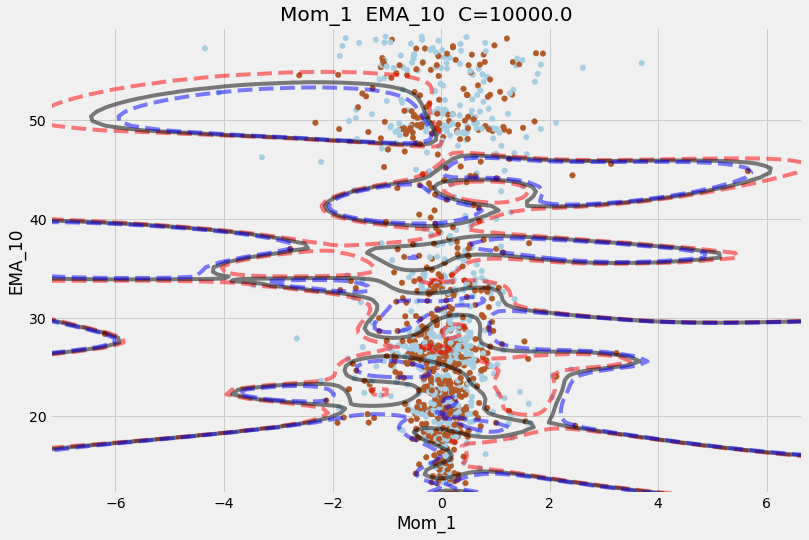

In [25]:
plot_hyperplane('Mom_1', 'EMA_10', C=1e4)

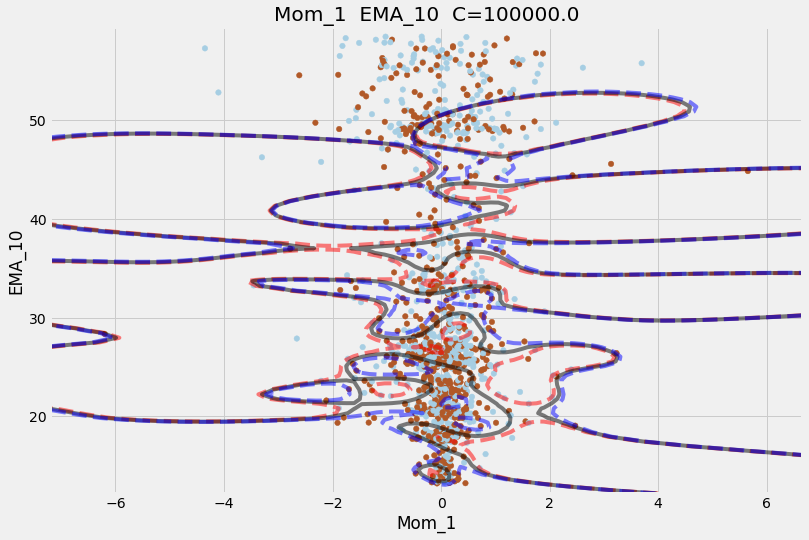

In [26]:
plot_hyperplane('Mom_1', 'EMA_10', C=1e5)

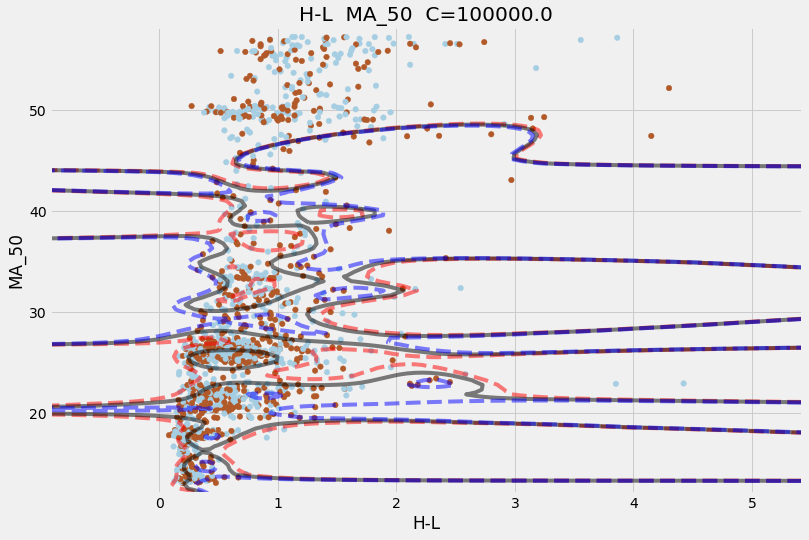

In [27]:
plot_hyperplane('H-L', 'MA_50', C=1e5)

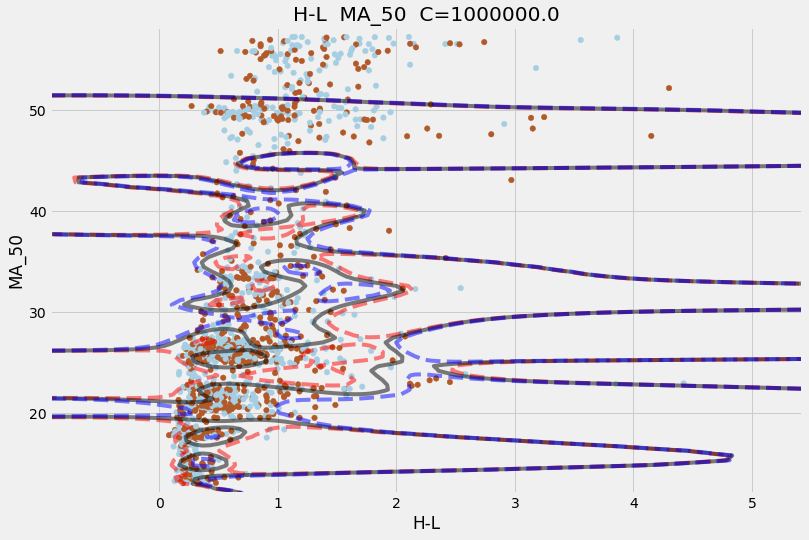

In [28]:
plot_hyperplane('H-L', 'MA_50', C=1e6)

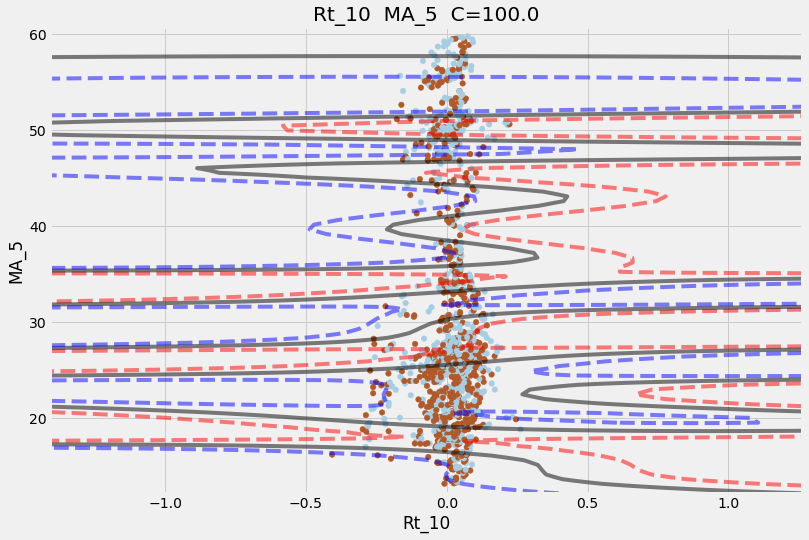

In [29]:
plot_hyperplane('Rt_10', 'MA_5', C=1e2)

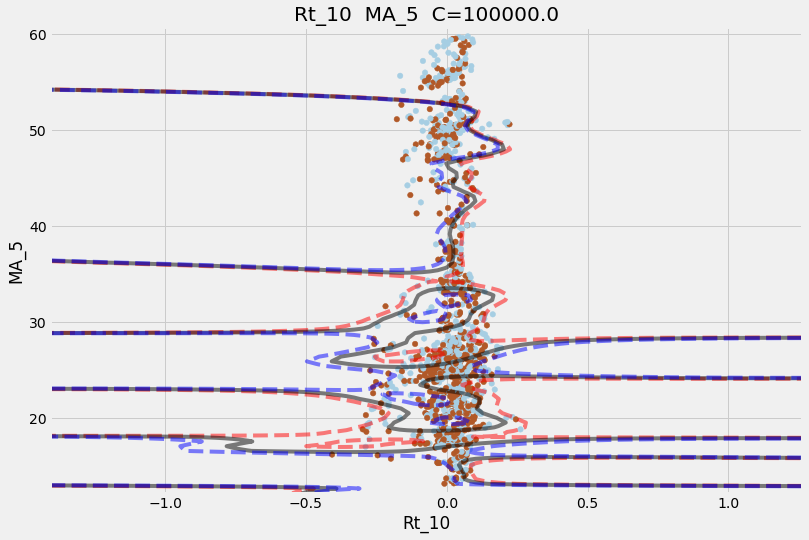

In [30]:
plot_hyperplane('Rt_10', 'MA_5', C=1e5)

In [31]:
def plot_hyperplane_type_2(f1, f2, C):
    y = DELL['Target'].values[:]
    
    X =  DELL[[f1,f2]].values[:]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    model = SVC(kernel='rbf', C=C, gamma=0.1, class_weight={1:0.93,-1:1})
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

    ax = plt.gca()
    DecisionBoundaryDisplay.from_estimator(
        model,
        X,
        plot_method="contour",
        colors=['r','k','b'],
        levels=[-1, 0, 1],
        alpha=0.5,
        linestyles=["--", '-', "--"],
        ax=ax,
    )
    plt.title('type (2)   '+f1+'  '+f2+'  '+'C='+str(C)+' '+'class_weight={1:0.93,-1:1}')
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.show()

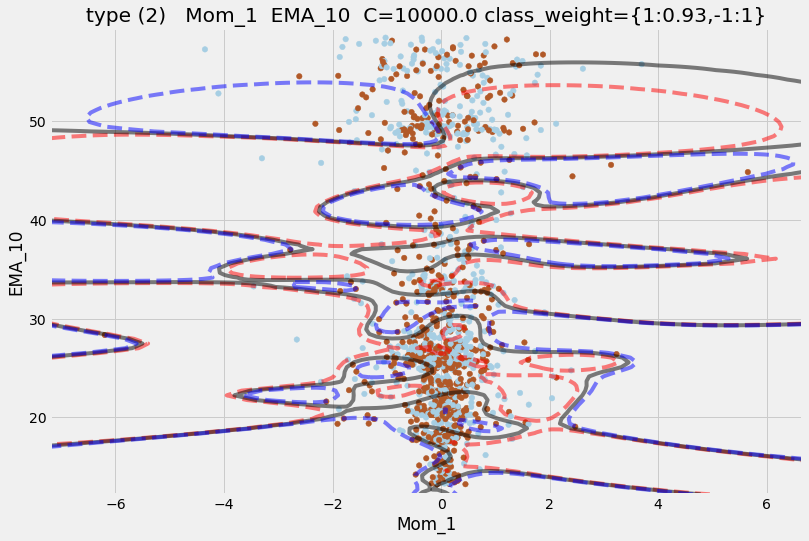

In [32]:
plot_hyperplane_type_2('Mom_1', 'EMA_10', C=1e4)

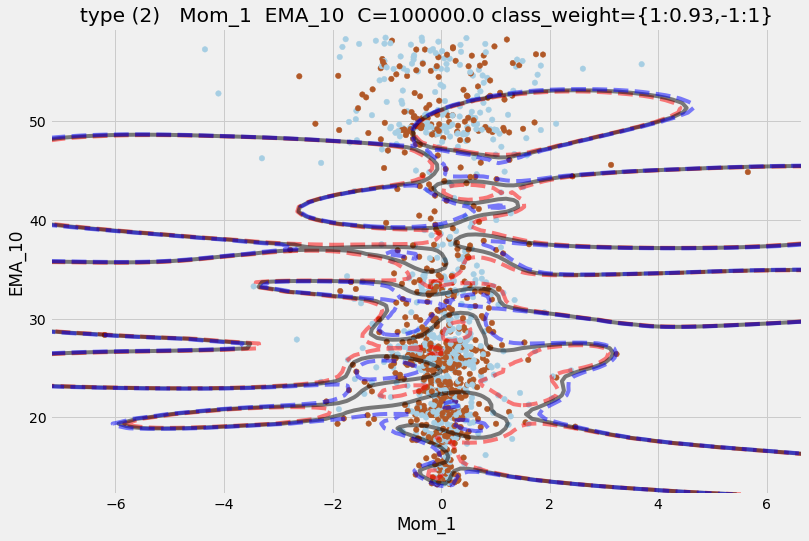

In [33]:
plot_hyperplane_type_2('Mom_1', 'EMA_10', C=1e5)

In [34]:
def plot_features(f1, f2):
    fig, ax = plt.subplots()
    ax.scatter(DELL[f1], DELL[f2], c=y, cmap=plt.cm.Paired)
    ax.set_xlabel(f1)
    ax.set_ylabel(f2)
    ax.set_title(f1+' & '+f2)

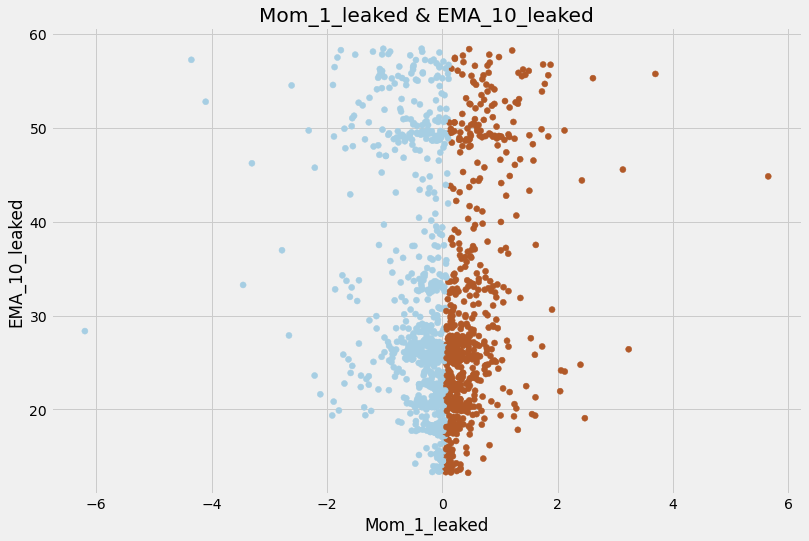

In [35]:
plot_features('Mom_1_leaked', 'EMA_10_leaked')

# Question 2 Bullet 4

## AUC

In [36]:
# calculate AUC
def AUC_cal(f1, f2, C, k='rbf', g=0.1, class_weight={1:1,-1:1}):
    
    y = DELL['Target'].values[:]
    
    X =  DELL[[f1,f2]].values[:]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)
    
    model = SVC(kernel=k, C=C, gamma=g, class_weight=class_weight)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    return roc_auc_score(y_test, model.decision_function(X_test))

In [37]:
AUC_df = pd.DataFrame(index=['Mom_1 & EMA_10 C=1e4', 'H-L & MA_50 C=1e5', 'Rt_10 & MA_5 C=1e2', 'type two Mom_1 & EMA_10 C=1e4 class_weight={1:0.93,-1:1}'], columns=['AUC'])

AUC_df.loc['Mom_1 & EMA_10 C=1e4','AUC'] = AUC_cal('Mom_1', 'EMA_10', C=1e4)
AUC_df.loc['H-L & MA_50 C=1e5','AUC'] = AUC_cal('H-L', 'MA_50', C=1e5)
AUC_df.loc['Rt_10 & MA_5 C=1e2','AUC'] = AUC_cal('Rt_10', 'MA_5', C=1e2)
AUC_df.loc['type two Mom_1 & EMA_10 C=1e4 class_weight={1:0.93,-1:1}', 'AUC'] = AUC_cal('Mom_1', 'EMA_10', C=1e4, class_weight={1:0.93,-1:1})

In [38]:
AUC_df

,AUC
Mom_1 & EMA_10 C=1e4,0.503476
H-L & MA_50 C=1e5,0.53897
Rt_10 & MA_5 C=1e2,0.512458
"type two Mom_1 & EMA_10 C=1e4 class_weight={1:0.93,-1:1}",0.497841


## Confusion Matix

In [39]:
def CM_cal(f1, f2, C, k='rbf', g=0.1, class_weight={1:1,-1:1}):
    
    y = DELL['Target'].values[:]
    
    X =  DELL[[f1, f2]].values[:]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)
    
    model = SVC(C=C, kernel=k, gamma=g, class_weight=class_weight)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    return confusion_matrix(y_test, y_pred).ravel()

In [40]:
CM_df = pd.DataFrame()
indicator_df = pd.DataFrame()

tn, fp, fn, tp = CM_cal('Mom_1', 'EMA_10', C=1e4)
CM_df = CM_df.append(pd.DataFrame({
    'models':['Mom_1 & EMA_10 C=1e4'],
    'true negatibe':[tn],
    'false positive':[fp],
    'false negative':[fn],
    'true positive':[tp]
}))
indicator_df = indicator_df.append(pd.DataFrame({
    'models':['Mom_1 & EMA_10 C=1e4'],
    'f1 score':[tp/(tp+0.5*(fp+fn))],
    'precision':[tp/(tp+fp)],
    'recall':[tp/(tp+fn)],
    'accuracy':[(tp+tn)/(tn+fp+fn+tp)],
    'balanced accuracy':[(tp/(tp+fn)+tn/(tn+fp))/2]
}))

tn, fp, fn, tp = CM_cal('H-L', 'MA_50', C=1e5)
CM_df = CM_df.append(pd.DataFrame({
    'models':['H-L & MA_50 C=1e5'],
    'true negatibe':[tn],
    'false positive':[fp],
    'false negative':[fn],
    'true positive':[tp]
}))
indicator_df = indicator_df.append(pd.DataFrame({
    'models':['H-L & MA_50 C=1e5'],
    'f1 score':[tp/(tp+0.5*(fp+fn))],
    'precision':[tp/(tp+fp)],
    'recall':[tp/(tp+fn)],
    'accuracy':[(tp+tn)/(tn+fp+fn+tp)],
    'balanced accuracy':[(tp/(tp+fn)+tn/(tn+fp))/2]
}))

tn, fp, fn, tp = CM_cal('Rt_10', 'MA_5', C=1e2)
CM_df = CM_df.append(pd.DataFrame({
    'models':['Rt_10 & MA_5 C=1e2'],
    'true negatibe':[tn],
    'false positive':[fp],
    'false negative':[fn],
    'true positive':[tp]
}))
indicator_df = indicator_df.append(pd.DataFrame({
    'models':['Rt_10 & MA_5 C=1e2'],
    'f1 score':[tp/(tp+0.5*(fp+fn))],
    'precision':[tp/(tp+fp)],
    'recall':[tp/(tp+fn)],
    'accuracy':[(tp+tn)/(tn+fp+fn+tp)],
    'balanced accuracy':[(tp/(tp+fn)+tn/(tn+fp))/2]
}))

tn, fp, fn, tp = CM_cal('Mom_1', 'EMA_10', C=1e4, class_weight={1:0.93,-1:1})
CM_df = CM_df.append(pd.DataFrame({
    'models':['type two Mom_1 & EMA_10 C=1e4 class_weight={1:0.93,-1:1}'],
    'true negatibe':[tn],
    'false positive':[fp],
    'false negative':[fn],
    'true positive':[tp]
}))
indicator_df = indicator_df.append(pd.DataFrame({
    'models':['type two Mom_1 & EMA_10 C=1e4 class_weight={1:0.93,-1:1}'],
    'f1 score':[tp/(tp+0.5*(fp+fn))],
    'precision':[tp/(tp+fp)],
    'recall':[tp/(tp+fn)],
    'accuracy':[(tp+tn)/(tn+fp+fn+tp)],
    'balanced accuracy':[(tp/(tp+fn)+tn/(tn+fp))/2]
}))

CM_df = CM_df.set_index('models')
indicator_df = indicator_df.set_index('models')

In [41]:
CM_df

,true negatibe,false positive,false negative,true positive
models,,,,
Mom_1 & EMA_10 C=1e4,299,74,271,63
H-L & MA_50 C=1e5,271,102,219,115
Rt_10 & MA_5 C=1e2,134,239,132,202
"type two Mom_1 & EMA_10 C=1e4 class_weight={1:0.93,-1:1}",302,71,280,54


In [42]:
indicator_df

,f1 score,precision,recall,accuracy,balanced accuracy
models,,,,,
Mom_1 & EMA_10 C=1e4,0.267516,0.459854,0.188623,0.512023,0.495116
H-L & MA_50 C=1e5,0.417423,0.529954,0.344311,0.545969,0.535426
Rt_10 & MA_5 C=1e2,0.521290,0.458050,0.604790,0.475248,0.482020
"type two Mom_1 & EMA_10 C=1e4 class_weight={1:0.93,-1:1}",0.235294,0.432000,0.161677,0.503536,0.485664


# Question 3

## scaler test with rbf (gamma=1 / (n_features * X.var())

In [43]:
def scaler_test(f1,f2,C,scaler_,class_weight={1:1,-1:1}):
    global scaler_df
    
    if scaler_ == 'None':
        y = DELL['Target'].values
        X =  DELL[[f1, f2]].values

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

        model = SVC(C=C, class_weight=class_weight)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        
        scaler_df = scaler_df.append(pd.DataFrame({
                'scaler':[scaler_],
                'train score':[model.score(X_train, y_train)],
                'test score':[model.score(X_test, y_test)],
                'AUC':[roc_auc_score(y_test, model.decision_function(X_test))],
                'f1 score':[f1_score(y_test, y_pred)],
                'balanced accuracy':[(tp/(tp+fn)+tn/(tn+fp))/2]
        }))
    
    else:
        y = DELL['Target'].values
        X =  DELL[[f1, f2]].values

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        scaler = scaler_
        scaler.fit(X_train)
        Xt_train = scaler.transform(X_train)
        Xt_test = scaler.transform(X_test)

        model = SVC(C=C, class_weight=class_weight)
        model.fit(Xt_train, y_train)

        y_pred = model.predict(Xt_test)
        
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        
        scaler_df = scaler_df.append(pd.DataFrame({
                'scaler':[scaler_],
                'train score':[model.score(Xt_train, y_train)],
                'test score':[model.score(Xt_test, y_test)],
                'AUC':[roc_auc_score(y_test, model.decision_function(Xt_test))],
                'f1 score':[f1_score(y_test, y_pred)],
                'balanced accuracy':[(tp/(tp+fn)+tn/(tn+fp))/2]
        }))

In [44]:
%%time
scaler_list = ['None', MinMaxScaler(), RobustScaler(), StandardScaler(), MaxAbsScaler(), QuantileTransformer(), PowerTransformer()]
scaler_df = pd.DataFrame()
for i in scaler_list:
    scaler_test('Mom_1', 'EMA_10', 1e4, i)
print('Mom_1 & EMA_10 scaler test with rbf')
scaler_df.set_index('scaler', inplace=True)    
scaler_df

Mom_1 & EMA_10 scaler test with rbf
Wall time: 9.61 s


,train score,test score,AUC,f1 score,balanced accuracy
scaler,,,,,
None,0.510168,0.590106,0.528284,0.107692,0.517217
MinMaxScaler(),0.543767,0.480565,0.477711,0.530351,0.510325
RobustScaler(),0.603006,0.547703,0.502613,0.471074,0.538276
StandardScaler(),0.595933,0.551237,0.515167,0.425339,0.529796
MaxAbsScaler(),0.526083,0.593640,0.539557,0.248366,0.534100
QuantileTransformer(),0.580018,0.498233,0.545219,0.544872,0.527875
PowerTransformer(),0.595049,0.544170,0.518036,0.351759,0.509864


In [45]:
scaler_df_selected = scaler_df.copy()
bad_ones = ()
for i in scaler_df.columns[:-1]:
    bad_ones += tuple(scaler_df_selected[scaler_df_selected[i]<(scaler_df_selected[i].mean()-scaler_df_selected[i].std())].index)
scaler_df_selected.drop(index = list(set(bad_ones)), inplace=True)
print('relative good combinations')
scaler_df_selected

relative good combinations


,train score,test score,AUC,f1 score,balanced accuracy
scaler,,,,,
RobustScaler(),0.603006,0.547703,0.502613,0.471074,0.538276
StandardScaler(),0.595933,0.551237,0.515167,0.425339,0.529796
PowerTransformer(),0.595049,0.544170,0.518036,0.351759,0.509864


In [46]:
%%time
scaler_df = pd.DataFrame()
for i in scaler_list:
    scaler_test('H-L', 'MA_50', 1e5, i)
print('H-L & MA_50 scaler test with rbf')    
scaler_df.set_index('scaler', inplace=True)
scaler_df

H-L & MA_50 scaler test with rbf
Wall time: 1min 32s


,train score,test score,AUC,f1 score,balanced accuracy
scaler,,,,,
None,0.525199,0.579505,0.493697,0.000000,0.500000
MinMaxScaler(),0.570292,0.455830,0.523622,0.527607,0.492442
RobustScaler(),0.598585,0.512367,0.528643,0.456693,0.508941
StandardScaler(),0.599469,0.533569,0.528233,0.410714,0.513399
MaxAbsScaler(),0.560566,0.491166,0.553751,0.547170,0.524083
QuantileTransformer(),0.585323,0.473498,0.521931,0.587258,0.530744
PowerTransformer(),0.593280,0.544170,0.544271,0.516854,0.549062


In [47]:
scaler_df_selected = scaler_df.copy()
bad_ones = ()
for i in scaler_df.columns[:-1]:
    bad_ones += tuple(scaler_df_selected[scaler_df_selected[i]<(scaler_df_selected[i].mean()-scaler_df_selected[i].std())].index)
scaler_df_selected.drop(index = list(set(bad_ones)), inplace=True)
print('relative good combinations')
scaler_df_selected

relative good combinations


,train score,test score,AUC,f1 score,balanced accuracy
scaler,,,,,
RobustScaler(),0.598585,0.512367,0.528643,0.456693,0.508941
StandardScaler(),0.599469,0.533569,0.528233,0.410714,0.513399
MaxAbsScaler(),0.560566,0.491166,0.553751,0.547170,0.524083
QuantileTransformer(),0.585323,0.473498,0.521931,0.587258,0.530744
PowerTransformer(),0.593280,0.544170,0.544271,0.516854,0.549062


In [48]:
%%time
scaler_df = pd.DataFrame()
for i in scaler_list:
    scaler_test('Rt_10', 'MA_5', 1e2, i)
print('Rt_10 & MA_5 scaler test with rbf')    
scaler_df.set_index('scaler', inplace=True)
scaler_df

Rt_10 & MA_5 scaler test with rbf
Wall time: 1.88 s


,train score,test score,AUC,f1 score,balanced accuracy
scaler,,,,,
None,0.524315,0.593640,0.561027,0.350282,0.547935
MinMaxScaler(),0.537577,0.558304,0.533665,0.390244,0.527823
RobustScaler(),0.566755,0.554770,0.559643,0.511628,0.554750
StandardScaler(),0.572060,0.537102,0.536893,0.523636,0.546423
MaxAbsScaler(),0.552608,0.579505,0.525159,0.190476,0.516141
QuantileTransformer(),0.566755,0.522968,0.501435,0.377880,0.498488
PowerTransformer(),0.572060,0.537102,0.537098,0.501901,0.539506


In [49]:
scaler_df_selected = scaler_df.copy()
bad_ones = ()
for i in scaler_df.columns[:-1]:
    bad_ones += tuple(scaler_df_selected[scaler_df_selected[i]<(scaler_df_selected[i].mean()-scaler_df_selected[i].std())].index)
scaler_df_selected.drop(index = list(set(bad_ones)), inplace=True)
print('relative good combinations')
scaler_df_selected

relative good combinations


,train score,test score,AUC,f1 score,balanced accuracy
scaler,,,,,
MinMaxScaler(),0.537577,0.558304,0.533665,0.390244,0.527823
RobustScaler(),0.566755,0.554770,0.559643,0.511628,0.554750
StandardScaler(),0.572060,0.537102,0.536893,0.523636,0.546423
PowerTransformer(),0.572060,0.537102,0.537098,0.501901,0.539506


In [50]:
%%time
scaler_df = pd.DataFrame()
for i in scaler_list:
    scaler_test('Mom_1', 'EMA_10', 1e4, i, class_weight={1:0.93,-1:1})
print('Mom_1 & EMA_10 class_weight={1:0.93,-1:1} scaler test with rbf')
scaler_df.set_index('scaler', inplace=True)
scaler_df

Mom_1 & EMA_10 class_weight={1:0.93,-1:1} scaler test with rbf
Wall time: 10.9 s


,train score,test score,AUC,f1 score,balanced accuracy
scaler,,,,,
None,0.515473,0.561837,0.514962,0.015873,0.485909
MinMaxScaler(),0.552608,0.473498,0.483808,0.504983,0.496157
RobustScaler(),0.604775,0.512367,0.500000,0.477273,0.514706
StandardScaler(),0.603890,0.537102,0.512246,0.422907,0.518754
MaxAbsScaler(),0.530504,0.575972,0.530232,0.178082,0.511939
QuantileTransformer(),0.588859,0.526502,0.554955,0.537931,0.544195
PowerTransformer(),0.594164,0.554770,0.514603,0.411215,0.529386


In [51]:
scaler_df_selected = scaler_df.copy()
bad_ones = ()
for i in scaler_df.columns[:-1]:
    bad_ones += tuple(scaler_df_selected[scaler_df_selected[i]<(scaler_df_selected[i].mean()-scaler_df_selected[i].std())].index)
scaler_df_selected.drop(index = list(set(bad_ones)), inplace=True)
print('relative good combinations')
scaler_df_selected

relative good combinations


,train score,test score,AUC,f1 score,balanced accuracy
scaler,,,,,
RobustScaler(),0.604775,0.512367,0.500000,0.477273,0.514706
StandardScaler(),0.603890,0.537102,0.512246,0.422907,0.518754
QuantileTransformer(),0.588859,0.526502,0.554955,0.537931,0.544195
PowerTransformer(),0.594164,0.554770,0.514603,0.411215,0.529386


## scaler test with sigmoid

In [52]:
def scaler_test(f1,f2,C,scaler_,class_weight={1:1,-1:1}):
    global scaler_df
    
    if scaler_ == 'None':
        y = DELL['Target'].values
        X =  DELL[[f1, f2]].values

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

        model = SVC(C=C, kernel='sigmoid', class_weight=class_weight)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        scaler_df = scaler_df.append(pd.DataFrame({
                'scaler':[scaler_],
                'train score':[model.score(X_train, y_train)],
                'test score':[model.score(X_test, y_test)],
                'AUC':[roc_auc_score(y_test, model.decision_function(X_test))],
                'f1 score':[f1_score(y_test, y_pred)],
                'balanced accuracy':[(tp/(tp+fn)+tn/(tn+fp))/2]
        }))
    
    else:
        y = DELL['Target'].values
        X =  DELL[[f1, f2]].values

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        scaler = scaler_
        scaler.fit(X_train)
        Xt_train = scaler.transform(X_train)
        Xt_test = scaler.transform(X_test)

        model = SVC(C=C, kernel='sigmoid', class_weight=class_weight)
        model.fit(Xt_train, y_train)

        y_pred = model.predict(Xt_test)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        scaler_df = scaler_df.append(pd.DataFrame({
                'scaler':[scaler_],
                'train score':[model.score(Xt_train, y_train)],
                'test score':[model.score(Xt_test, y_test)],
                'AUC':[roc_auc_score(y_test, model.decision_function(Xt_test))],
                'f1 score':[f1_score(y_test, y_pred)],
                'balanced accuracy':[(tp/(tp+fn)+tn/(tn+fp))/2]
        }))

In [53]:
%%time
scaler_list = ['None', MinMaxScaler(), RobustScaler(), StandardScaler(), MaxAbsScaler(), QuantileTransformer(), PowerTransformer()]
scaler_df = pd.DataFrame()
for i in scaler_list:
    scaler_test('Mom_1', 'EMA_10', 1e4, i)
print('Mom_1 & EMA_10 scaler test with sigmoid')
scaler_df.set_index('scaler', inplace=True)
scaler_df

Mom_1 & EMA_10 scaler test with sigmoid
Wall time: 762 ms


,train score,test score,AUC,f1 score,balanced accuracy
scaler,,,,,
None,0.478338,0.420495,0.459572,0.592040,0.500000
MinMaxScaler(),0.478338,0.427562,0.480375,0.590909,0.503792
RobustScaler(),0.496905,0.526502,0.474944,0.407080,0.507302
StandardScaler(),0.496021,0.413428,0.454294,0.585000,0.491597
MaxAbsScaler(),0.476569,0.420495,0.459725,0.592040,0.500000
QuantileTransformer(),0.481874,0.438163,0.482835,0.468227,0.458752
PowerTransformer(),0.503095,0.427562,0.452757,0.590909,0.503792


In [54]:
scaler_df_selected = scaler_df.copy()
bad_ones = ()
for i in scaler_df.columns[:-1]:
    bad_ones += tuple(scaler_df_selected[scaler_df_selected[i]<(scaler_df_selected[i].mean()-scaler_df_selected[i].std())].index)
scaler_df_selected.drop(index = list(set(bad_ones)), inplace=True)
print('relative good combinations')
scaler_df_selected

relative good combinations


,train score,test score,AUC,f1 score,balanced accuracy
scaler,,,,,
None,0.478338,0.420495,0.459572,0.592040,0.500000
MinMaxScaler(),0.478338,0.427562,0.480375,0.590909,0.503792
StandardScaler(),0.496021,0.413428,0.454294,0.585000,0.491597
MaxAbsScaler(),0.476569,0.420495,0.459725,0.592040,0.500000


In [55]:
%%time
scaler_df = pd.DataFrame()
for i in scaler_list:
    scaler_test('H-L', 'MA_50', 1e5, i)
print('H-L & MA_50 scaler test with sigmoid')    
scaler_df.set_index('scaler', inplace=True)
scaler_df

H-L & MA_50 scaler test with sigmoid
Wall time: 715 ms


,train score,test score,AUC,f1 score,balanced accuracy
scaler,,,,,
None,0.497790,0.420495,0.482988,0.592040,0.500000
MinMaxScaler(),0.506631,0.579505,0.510658,0.000000,0.500000
RobustScaler(),0.517241,0.420495,0.476532,0.592040,0.500000
StandardScaler(),0.504863,0.420495,0.477403,0.592040,0.500000
MaxAbsScaler(),0.504863,0.579505,0.494569,0.000000,0.500000
QuantileTransformer(),0.497790,0.579505,0.472689,0.000000,0.500000
PowerTransformer(),0.508400,0.420495,0.505636,0.585859,0.496541


In [56]:
scaler_df_selected = scaler_df.copy()
bad_ones = ()
for i in scaler_df.columns[:-1]:
    bad_ones += tuple(scaler_df_selected[scaler_df_selected[i]<(scaler_df_selected[i].mean()-scaler_df_selected[i].std())].index)
scaler_df_selected.drop(index = list(set(bad_ones)), inplace=True)
print('relative good combinations')
scaler_df_selected

relative good combinations


,train score,test score,AUC,f1 score,balanced accuracy
scaler,,,,,
RobustScaler(),0.517241,0.420495,0.476532,0.592040,0.500000
StandardScaler(),0.504863,0.420495,0.477403,0.592040,0.500000
PowerTransformer(),0.508400,0.420495,0.505636,0.585859,0.496541


In [57]:
%%time
scaler_df = pd.DataFrame()
for i in scaler_list:
    scaler_test('Rt_10', 'MA_5', 1e2, i)
print('Rt_10 & MA_5 scaler test with sigmoid')    
scaler_df.set_index('scaler', inplace=True)
scaler_df

Rt_10 & MA_5 scaler test with sigmoid
Wall time: 735 ms


,train score,test score,AUC,f1 score,balanced accuracy
scaler,,,,,
None,0.515473,0.579505,0.561181,0.000000,0.500000
MinMaxScaler(),0.476569,0.420495,0.436052,0.592040,0.500000
RobustScaler(),0.489832,0.565371,0.541863,0.320442,0.521239
StandardScaler(),0.502210,0.420495,0.447069,0.570681,0.488471
MaxAbsScaler(),0.522546,0.579505,0.553597,0.000000,0.500000
QuantileTransformer(),0.490716,0.431095,0.460545,0.498442,0.464183
PowerTransformer(),0.480990,0.565371,0.545501,0.151724,0.500487


In [58]:
scaler_df_selected = scaler_df.copy()
bad_ones = ()
for i in scaler_df.columns[:-1]:
    bad_ones += tuple(scaler_df_selected[scaler_df_selected[i]<(scaler_df_selected[i].mean()-scaler_df_selected[i].std())].index)
scaler_df_selected.drop(index = list(set(bad_ones)), inplace=True)
print('relative good combinations')
scaler_df_selected

relative good combinations


,train score,test score,AUC,f1 score,balanced accuracy
scaler,,,,,
RobustScaler(),0.489832,0.565371,0.541863,0.320442,0.521239
QuantileTransformer(),0.490716,0.431095,0.460545,0.498442,0.464183
PowerTransformer(),0.480990,0.565371,0.545501,0.151724,0.500487


In [59]:
%%time
scaler_df = pd.DataFrame()
for i in scaler_list:
    scaler_test('Mom_1', 'EMA_10', 1e4, i, class_weight={1:0.93,-1:1})
print('Mom_1 & EMA_10 class_weight={1:0.93,-1:1} scaler test with sigmoid')
scaler_df.set_index('scaler', inplace=True)
scaler_df

Mom_1 & EMA_10 class_weight={1:0.93,-1:1} scaler test with sigmoid
Wall time: 765 ms


,train score,test score,AUC,f1 score,balanced accuracy
scaler,,,,,
None,0.477454,0.420495,0.459623,0.592040,0.500000
MinMaxScaler(),0.478338,0.427562,0.480375,0.590909,0.503792
RobustScaler(),0.500442,0.537102,0.478838,0.384977,0.510684
StandardScaler(),0.494253,0.413428,0.456702,0.585000,0.491597
MaxAbsScaler(),0.475685,0.420495,0.459315,0.592040,0.500000
QuantileTransformer(),0.486295,0.441696,0.482911,0.462585,0.459495
PowerTransformer(),0.501326,0.427562,0.453577,0.590909,0.503792


In [60]:
scaler_df_selected = scaler_df.copy()
bad_ones = ()
for i in scaler_df.columns[:-1]:
    bad_ones += tuple(scaler_df_selected[scaler_df_selected[i]<(scaler_df_selected[i].mean()-scaler_df_selected[i].std())].index)
scaler_df_selected.drop(index = list(set(bad_ones)), inplace=True)
print('relative good combinations')
scaler_df_selected

relative good combinations


,train score,test score,AUC,f1 score,balanced accuracy
scaler,,,,,
None,0.477454,0.420495,0.459623,0.592040,0.500000
MinMaxScaler(),0.478338,0.427562,0.480375,0.590909,0.503792
StandardScaler(),0.494253,0.413428,0.456702,0.585000,0.491597
QuantileTransformer(),0.486295,0.441696,0.482911,0.462585,0.459495


## scaler test with polynomial

In [61]:
def scaler_test(f1,f2,C,scaler_,class_weight={1:1,-1:1}):
    global scaler_df
    
    if scaler_ == 'None':
        y = DELL['Target'].values
        X =  DELL[[f1, f2]].values

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

        model = SVC(C=C, kernel='poly', class_weight=class_weight)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        scaler_df = scaler_df.append(pd.DataFrame({
                'scaler':[scaler_],
                'train score':[model.score(X_train, y_train)],
                'test score':[model.score(X_test, y_test)],
                'AUC':[roc_auc_score(y_test, model.decision_function(X_test))],
                'f1 score':[f1_score(y_test, y_pred)],
                'balanced accuracy':[(tp/(tp+fn)+tn/(tn+fp))/2]
        }))
    
    else:
        y = DELL['Target'].values
        X =  DELL[[f1, f2]].values

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        scaler = scaler_
        scaler.fit(X_train)
        Xt_train = scaler.transform(X_train)
        Xt_test = scaler.transform(X_test)

        model = SVC(C=C, kernel='poly', class_weight=class_weight)
        model.fit(Xt_train, y_train)

        y_pred = model.predict(Xt_test)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        scaler_df = scaler_df.append(pd.DataFrame({
                'scaler':[scaler_],
                'train score':[model.score(Xt_train, y_train)],
                'test score':[model.score(Xt_test, y_test)],
                'AUC':[roc_auc_score(y_test, model.decision_function(Xt_test))],
                'f1 score':[f1_score(y_test, y_pred)],
                'balanced accuracy':[(tp/(tp+fn)+tn/(tn+fp))/2]
        }))

In [62]:
%%time
scaler_list = ['None', MinMaxScaler(), RobustScaler(), StandardScaler(), MaxAbsScaler(), QuantileTransformer(), PowerTransformer()]
scaler_df = pd.DataFrame()
for i in scaler_list:
    scaler_test('Mom_1', 'EMA_10', 1e4, i)
print('Mom_1 & EMA_10 scaler test with poly')
scaler_df.set_index('scaler', inplace=True)
scaler_df

Mom_1 & EMA_10 scaler test with poly
Wall time: 7min 7s


,train score,test score,AUC,f1 score,balanced accuracy
scaler,,,,,
None,0.506631,0.519435,0.507942,0.339806,0.488522
MinMaxScaler(),0.511936,0.515901,0.495542,0.486891,0.520060
RobustScaler(),0.504863,0.522968,0.501435,0.347826,0.492724
StandardScaler(),0.506631,0.519435,0.501998,0.333333,0.487369
MaxAbsScaler(),0.507515,0.537102,0.508455,0.407240,0.515295
QuantileTransformer(),0.526083,0.537102,0.517191,0.473896,0.531436
PowerTransformer(),0.505747,0.579505,0.512451,0.000000,0.500000


In [63]:
scaler_df_selected = scaler_df.copy()
bad_ones = ()
for i in scaler_df.columns[:-1]:
    bad_ones += tuple(scaler_df_selected[scaler_df_selected[i]<(scaler_df_selected[i].mean()-scaler_df_selected[i].std())].index)
scaler_df_selected.drop(index = list(set(bad_ones)), inplace=True)
print('relative good combinations')
scaler_df_selected

relative good combinations


,train score,test score,AUC,f1 score,balanced accuracy
scaler,,,,,
None,0.506631,0.519435,0.507942,0.339806,0.488522
RobustScaler(),0.504863,0.522968,0.501435,0.347826,0.492724
StandardScaler(),0.506631,0.519435,0.501998,0.333333,0.487369
MaxAbsScaler(),0.507515,0.537102,0.508455,0.407240,0.515295
QuantileTransformer(),0.526083,0.537102,0.517191,0.473896,0.531436


In [64]:
%%time
scaler_df = pd.DataFrame()
for i in scaler_list:
    scaler_test('H-L', 'MA_50', 1e5, i)
print('H-L & MA_50 scaler test with poly')    
scaler_df.set_index('scaler', inplace=True)
scaler_df

H-L & MA_50 scaler test with poly
Wall time: 21min 33s


,train score,test score,AUC,f1 score,balanced accuracy
scaler,,,,,
None,0.519010,0.455830,0.519420,0.541667,0.498207
MinMaxScaler(),0.505747,0.530035,0.520240,0.369668,0.502280
RobustScaler(),0.515473,0.466431,0.501486,0.520635,0.496977
StandardScaler(),0.513705,0.533569,0.513784,0.359223,0.503023
MaxAbsScaler(),0.519894,0.579505,0.518498,0.242038,0.521905
QuantileTransformer(),0.511936,0.473498,0.527465,0.580282,0.527285
PowerTransformer(),0.506631,0.572438,0.525364,0.316384,0.526184


In [65]:
scaler_df_selected = scaler_df.copy()
bad_ones = ()
for i in scaler_df.columns[:-1]:
    bad_ones += tuple(scaler_df_selected[scaler_df_selected[i]<(scaler_df_selected[i].mean()-scaler_df_selected[i].std())].index)
scaler_df_selected.drop(index = list(set(bad_ones)), inplace=True)
print('relative good combinations')
scaler_df_selected

relative good combinations


,train score,test score,AUC,f1 score,balanced accuracy
scaler,,,,,
StandardScaler(),0.513705,0.533569,0.513784,0.359223,0.503023
QuantileTransformer(),0.511936,0.473498,0.527465,0.580282,0.527285


In [66]:
%%time
scaler_df = pd.DataFrame()
for i in scaler_list:
    scaler_test('Rt_10', 'MA_5', 1e2, i)
print('Rt_10 & MA_5 scaler test with poly')    
scaler_df.set_index('scaler', inplace=True)
scaler_df

Rt_10 & MA_5 scaler test with poly
Wall time: 9.39 s


,train score,test score,AUC,f1 score,balanced accuracy
scaler,,,,,
None,0.505747,0.579505,0.525620,0.000000,0.500000
MinMaxScaler(),0.511052,0.424028,0.495491,0.585242,0.498437
RobustScaler(),0.506631,0.420495,0.503484,0.579487,0.493083
StandardScaler(),0.510168,0.416961,0.500256,0.564644,0.483116
MaxAbsScaler(),0.504863,0.491166,0.546885,0.526316,0.516013
QuantileTransformer(),0.506631,0.501767,0.538994,0.534653,0.526312
PowerTransformer(),0.506631,0.519435,0.521265,0.480916,0.520803


In [67]:
scaler_df_selected = scaler_df.copy()
bad_ones = ()
for i in scaler_df.columns[:-1]:
    bad_ones += tuple(scaler_df_selected[scaler_df_selected[i]<(scaler_df_selected[i].mean()-scaler_df_selected[i].std())].index)
scaler_df_selected.drop(index = list(set(bad_ones)), inplace=True)
print('relative good combinations')
scaler_df_selected

relative good combinations


,train score,test score,AUC,f1 score,balanced accuracy
scaler,,,,,
RobustScaler(),0.506631,0.420495,0.503484,0.579487,0.493083
QuantileTransformer(),0.506631,0.501767,0.538994,0.534653,0.526312
PowerTransformer(),0.506631,0.519435,0.521265,0.480916,0.520803


In [68]:
%%time
scaler_df = pd.DataFrame()
for i in scaler_list:
    scaler_test('Mom_1', 'EMA_10', 1e4, i, class_weight={1:0.93,-1:1})
print('Mom_1 & EMA_10 class_weight={1:0.93,-1:1} scaler test with poly')
scaler_df.set_index('scaler', inplace=True)
scaler_df

Mom_1 & EMA_10 class_weight={1:0.93,-1:1} scaler test with poly
Wall time: 10min 58s


,train score,test score,AUC,f1 score,balanced accuracy
scaler,,,,,
None,0.508400,0.544170,0.510709,0.198758,0.487959
MinMaxScaler(),0.519010,0.494700,0.501281,0.274112,0.457958
RobustScaler(),0.507515,0.544170,0.505893,0.227545,0.491417
StandardScaler(),0.507515,0.561837,0.502203,0.162162,0.498591
MaxAbsScaler(),0.507515,0.512367,0.510658,0.241758,0.467437
QuantileTransformer(),0.510168,0.537102,0.516832,0.505660,0.540659
PowerTransformer(),0.505747,0.579505,0.512759,0.000000,0.500000


In [69]:
scaler_df_selected = scaler_df.copy()
bad_ones = ()
for i in scaler_df.columns[:-1]:
    bad_ones += tuple(scaler_df_selected[scaler_df_selected[i]<(scaler_df_selected[i].mean()-scaler_df_selected[i].std())].index)
scaler_df_selected.drop(index = list(set(bad_ones)), inplace=True)
print('relative good combinations')
scaler_df_selected

relative good combinations


,train score,test score,AUC,f1 score,balanced accuracy
scaler,,,,,
None,0.508400,0.544170,0.510709,0.198758,0.487959
RobustScaler(),0.507515,0.544170,0.505893,0.227545,0.491417
MaxAbsScaler(),0.507515,0.512367,0.510658,0.241758,0.467437
QuantileTransformer(),0.510168,0.537102,0.516832,0.505660,0.540659


## scaler test with linear

In [70]:
def scaler_test(f1,f2,C,scaler_,class_weight={1:1,-1:1}):
    global scaler_df
    
    if scaler_ == 'None':
        y = DELL['Target'].values
        X =  DELL[[f1, f2]].values

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

        model = SVC(C=C, kernel='linear', class_weight=class_weight)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        scaler_df = scaler_df.append(pd.DataFrame({
                'scaler':[scaler_],
                'train score':[model.score(X_train, y_train)],
                'test score':[model.score(X_test, y_test)],
                'AUC':[roc_auc_score(y_test, model.decision_function(X_test))],
                'f1 score':[f1_score(y_test, y_pred)],
                'balanced accuracy':[(tp/(tp+fn)+tn/(tn+fp))/2]
        }))
    
    else:
        y = DELL['Target'].values
        X =  DELL[[f1, f2]].values

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        scaler = scaler_
        scaler.fit(X_train)
        Xt_train = scaler.transform(X_train)
        Xt_test = scaler.transform(X_test)

        model = SVC(C=C, kernel='linear', class_weight=class_weight)
        model.fit(Xt_train, y_train)

        y_pred = model.predict(Xt_test)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        scaler_df = scaler_df.append(pd.DataFrame({
                'scaler':[scaler_],
                'train score':[model.score(Xt_train, y_train)],
                'test score':[model.score(Xt_test, y_test)],
                'AUC':[roc_auc_score(y_test, model.decision_function(Xt_test))],
                'f1 score':[f1_score(y_test, y_pred)],
                'balanced accuracy':[(tp/(tp+fn)+tn/(tn+fp))/2]
        }))

In [71]:
%%time
scaler_list = ['None', MinMaxScaler(), RobustScaler(), StandardScaler(), MaxAbsScaler(), QuantileTransformer(), PowerTransformer()]
scaler_df = pd.DataFrame()
for i in scaler_list:
    scaler_test('Mom_1', 'EMA_10', 1e4, i)
print('Mom_1 & EMA_10 scaler test with linear')
scaler_df.set_index('scaler', inplace=True)
scaler_df

Mom_1 & EMA_10 scaler test with linear
Wall time: 46.2 s


,train score,test score,AUC,f1 score,balanced accuracy
scaler,,,,,
None,0.513705,0.445230,0.502921,0.594315,0.516730
MinMaxScaler(),0.505747,0.575972,0.528848,0.000000,0.496951
RobustScaler(),0.505747,0.579505,0.528489,0.000000,0.500000
StandardScaler(),0.507515,0.572438,0.529002,0.000000,0.493902
MaxAbsScaler(),0.505747,0.575972,0.528592,0.000000,0.496951
QuantileTransformer(),0.514589,0.544170,0.516474,0.509506,0.546757
PowerTransformer(),0.524315,0.568905,0.528797,0.000000,0.490854


In [72]:
scaler_df_selected = scaler_df.copy()
bad_ones = ()
for i in scaler_df.columns[:-1]:
    bad_ones += tuple(scaler_df_selected[scaler_df_selected[i]<(scaler_df_selected[i].mean()-scaler_df_selected[i].std())].index)
scaler_df_selected.drop(index = list(set(bad_ones)), inplace=True)
print('relative good combinations')
scaler_df_selected

relative good combinations


,train score,test score,AUC,f1 score,balanced accuracy
scaler,,,,,
MinMaxScaler(),0.505747,0.575972,0.528848,0.000000,0.496951
RobustScaler(),0.505747,0.579505,0.528489,0.000000,0.500000
StandardScaler(),0.507515,0.572438,0.529002,0.000000,0.493902
MaxAbsScaler(),0.505747,0.575972,0.528592,0.000000,0.496951
QuantileTransformer(),0.514589,0.544170,0.516474,0.509506,0.546757
PowerTransformer(),0.524315,0.568905,0.528797,0.000000,0.490854


In [73]:
%%time
scaler_df = pd.DataFrame()
for i in scaler_list:
    scaler_test('H-L', 'MA_50', 1e5, i)
print('H-L & MA_50 scaler test with linear')    
scaler_df.set_index('scaler', inplace=True)
scaler_df

H-L & MA_50 scaler test with linear
Wall time: 2min 3s


,train score,test score,AUC,f1 score,balanced accuracy
scaler,,,,,
None,0.503979,0.579505,0.525927,0.000000,0.500000
MinMaxScaler(),0.505747,0.593640,0.529002,0.217687,0.530642
RobustScaler(),0.503095,0.604240,0.527875,0.188406,0.536329
StandardScaler(),0.511936,0.586572,0.528336,0.254777,0.529156
MaxAbsScaler(),0.504863,0.583039,0.528848,0.233766,0.523801
QuantileTransformer(),0.515473,0.491166,0.527362,0.563636,0.531000
PowerTransformer(),0.526083,0.600707,0.533921,0.150376,0.529822


In [74]:
scaler_df_selected = scaler_df.copy()
bad_ones = ()
for i in scaler_df.columns[:-1]:
    bad_ones += tuple(scaler_df_selected[scaler_df_selected[i]<(scaler_df_selected[i].mean()-scaler_df_selected[i].std())].index)
scaler_df_selected.drop(index = list(set(bad_ones)), inplace=True)
print('relative good combinations')
scaler_df_selected

relative good combinations


,train score,test score,AUC,f1 score,balanced accuracy
scaler,,,,,
MinMaxScaler(),0.505747,0.593640,0.529002,0.217687,0.530642
RobustScaler(),0.503095,0.604240,0.527875,0.188406,0.536329
StandardScaler(),0.511936,0.586572,0.528336,0.254777,0.529156
MaxAbsScaler(),0.504863,0.583039,0.528848,0.233766,0.523801
PowerTransformer(),0.526083,0.600707,0.533921,0.150376,0.529822


In [75]:
%%time
scaler_df = pd.DataFrame()
for i in scaler_list:
    scaler_test('Rt_10', 'MA_5', 1e2, i)
print('Rt_10 & MA_5 scaler test with linear')    
scaler_df.set_index('scaler', inplace=True)
scaler_df

Rt_10 & MA_5 scaler test with linear
Wall time: 1.54 s


,train score,test score,AUC,f1 score,balanced accuracy
scaler,,,,,
None,0.511936,0.579505,0.554109,0.0,0.5
MinMaxScaler(),0.510168,0.579505,0.553546,0.0,0.5
RobustScaler(),0.510168,0.579505,0.553648,0.0,0.5
StandardScaler(),0.510168,0.579505,0.553546,0.0,0.5
MaxAbsScaler(),0.510168,0.579505,0.553597,0.0,0.5
QuantileTransformer(),0.515473,0.579505,0.540121,0.0,0.5
PowerTransformer(),0.518126,0.579505,0.553238,0.0,0.5


In [76]:
scaler_df_selected = scaler_df.copy()
bad_ones = ()
for i in scaler_df.columns[:-1]:
    bad_ones += tuple(scaler_df_selected[scaler_df_selected[i]<(scaler_df_selected[i].mean()-scaler_df_selected[i].std())].index)
scaler_df_selected.drop(index = list(set(bad_ones)), inplace=True)
print('relative good combinations')
scaler_df_selected

relative good combinations


,train score,test score,AUC,f1 score,balanced accuracy
scaler,,,,,
None,0.511936,0.579505,0.554109,0.0,0.5
MinMaxScaler(),0.510168,0.579505,0.553546,0.0,0.5
RobustScaler(),0.510168,0.579505,0.553648,0.0,0.5
StandardScaler(),0.510168,0.579505,0.553546,0.0,0.5
MaxAbsScaler(),0.510168,0.579505,0.553597,0.0,0.5
PowerTransformer(),0.518126,0.579505,0.553238,0.0,0.5


In [77]:
%%time
scaler_df = pd.DataFrame()
for i in scaler_list:
    scaler_test('Mom_1', 'EMA_10', 1e4, i, class_weight={1:0.93,-1:1})
print('Mom_1 & EMA_10 class_weight={1:0.93,-1:1} scaler test with linear')
scaler_df.set_index('scaler', inplace=True)
scaler_df

Mom_1 & EMA_10 class_weight={1:0.93,-1:1} scaler test with linear
Wall time: 2min 22s


,train score,test score,AUC,f1 score,balanced accuracy
scaler,,,,,
None,0.505747,0.579505,0.528336,0.0,0.5
MinMaxScaler(),0.505747,0.579505,0.520803,0.0,0.5
RobustScaler(),0.505747,0.579505,0.513579,0.0,0.5
StandardScaler(),0.505747,0.579505,0.520906,0.0,0.5
MaxAbsScaler(),0.505747,0.579505,0.519625,0.0,0.5
QuantileTransformer(),0.505747,0.579505,0.516320,0.0,0.5
PowerTransformer(),0.505747,0.579505,0.520189,0.0,0.5


In [78]:
scaler_df_selected = scaler_df.copy()
bad_ones = ()
for i in scaler_df.columns[:-1]:
    bad_ones += tuple(scaler_df_selected[scaler_df_selected[i]<(scaler_df_selected[i].mean()-scaler_df_selected[i].std())].index)
scaler_df_selected.drop(index = list(set(bad_ones)), inplace=True)
print('relative good combinations')
scaler_df_selected

relative good combinations


,train score,test score,AUC,f1 score,balanced accuracy
scaler,,,,,
None,0.505747,0.579505,0.528336,0.0,0.5
MinMaxScaler(),0.505747,0.579505,0.520803,0.0,0.5
StandardScaler(),0.505747,0.579505,0.520906,0.0,0.5
MaxAbsScaler(),0.505747,0.579505,0.519625,0.0,0.5
QuantileTransformer(),0.505747,0.579505,0.516320,0.0,0.5
PowerTransformer(),0.505747,0.579505,0.520189,0.0,0.5


## gamma test

In [79]:
def gamma_test(g):    
    y = DELL['Target'].values
    X =  DELL[['Mom_1', 'EMA_10']].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    scaler = StandardScaler()
    scaler.fit(X_train)
    Xt_train = scaler.transform(X_train)
    Xt_test = scaler.transform(X_test)

    model = SVC(C=1e4, kernel='rbf', gamma=g)
    model.fit(Xt_train, y_train)

    y_pred = model.predict(Xt_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    print('train score:'+str(model.score(Xt_train, y_train)))
    print('test score:'+str(model.score(Xt_test, y_test)))
    print('AUC:'+str(roc_auc_score(y_test, model.decision_function(Xt_test))))
    print('f1 score:'+str(f1_score(y_test, y_pred)))
    print('balanced accuracy:'+str((tp/(tp+fn)+tn/(tn+fp))/2))
    print('\n')

In [80]:
g_list = ['scale', 'auto', 1e-6, 1e-5, 1e-4, 1e-3, 0.01, 0.1, 1, 10, 100]
for i in g_list:
    print('gamma='+str(i))
    gamma_test(i)

gamma=scale
train score:0.5959328028293546
test score:0.5512367491166078
AUC:0.5151670424267267
f1 score:0.4253393665158371
balanced accuracy:0.5297960647673704


gamma=auto
train score:0.5959328028293546
test score:0.5512367491166078
AUC:0.5151670424267267
f1 score:0.4253393665158371
balanced accuracy:0.5297960647673704


gamma=1e-06
train score:0.5057471264367817
test score:0.5795053003533569
AUC:0.5227505636400902
f1 score:0.0
balanced accuracy:0.5


gamma=1e-05
train score:0.5057471264367817
test score:0.5724381625441696
AUC:0.527054724328756
f1 score:0.0
balanced accuracy:0.49390243902439024


gamma=0.0001
train score:0.506631299734748
test score:0.5724381625441696
AUC:0.5250563640090182
f1 score:0.016260162601626015
balanced accuracy:0.49505533920885425


gamma=0.001
train score:0.506631299734748
test score:0.4558303886925795
AUC:0.45834187333469967
f1 score:0.3937007874015748
balanced accuracy:0.45093769215003077


gamma=0.01
train score:0.519893899204244
test score:0.5547703180

# Question 4

In [81]:
y = DELL['Target'].values
X =  DELL[['Mom_1', 'EMA_10']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
scaler = StandardScaler()
scaler.fit(X_train)
Xt_train = scaler.transform(X_train)
Xt_test = scaler.transform(X_test)

model = SVC(C=1e4, kernel='rbf', probability=True)
model.fit(Xt_train, y_train)

y_pred = model.predict(Xt_test)

In [82]:
backtest_df = DELL[-283:]
backtest_df['signal'] = y_pred
backtest_df['strategy'] = backtest_df['Rt_1']*backtest_df['signal'].shift(1).fillna(0)
backtest_df['cumulative_return'] = backtest_df['strategy'].cumsum()

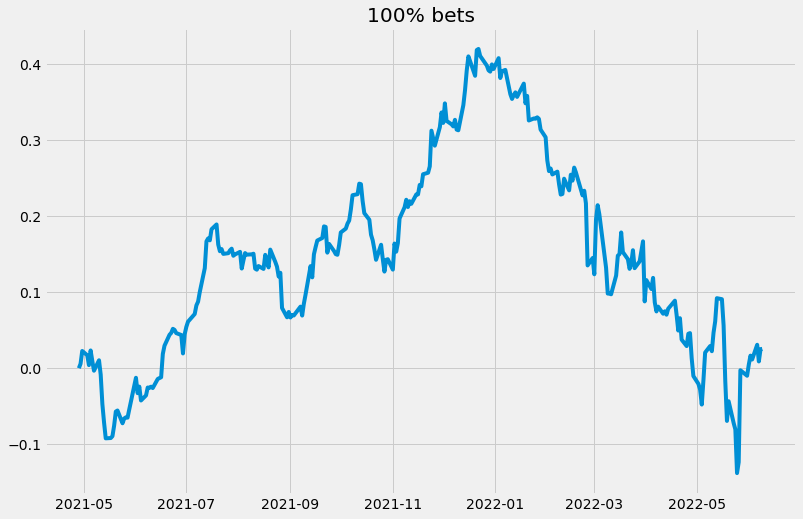

In [83]:
plt.plot(backtest_df['cumulative_return'])
plt.title('100% bets');

In [84]:
p = model.predict_proba(Xt_test)[:,0]
backtest_df['risky_allocation'] = 2*p-1
backtest_df['Kelly_strategy'] = backtest_df['Rt_1']*backtest_df['risky_allocation'].shift(1).fillna(0)
backtest_df['Kelly_cumulative_return'] = backtest_df['Kelly_strategy'].cumsum()

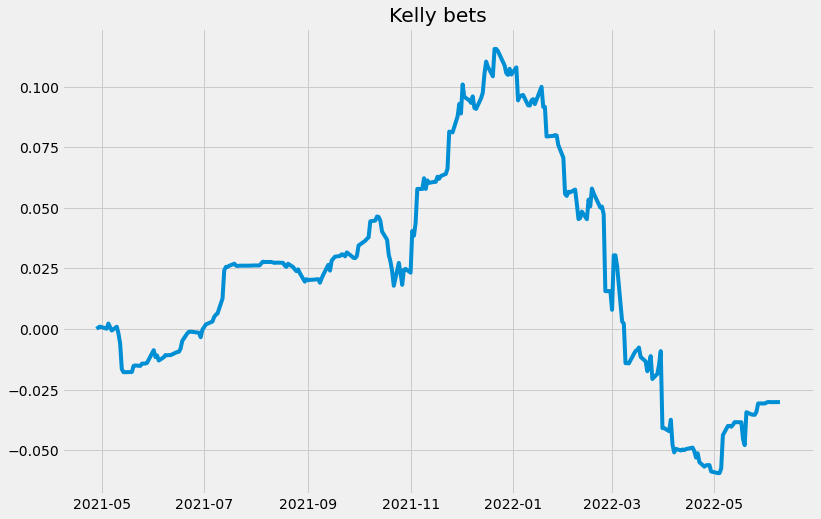

In [85]:
plt.plot(backtest_df['Kelly_cumulative_return'])
plt.title('Kelly bets');